<a href="https://colab.research.google.com/github/sitialiya/prediksi-penjualan-coffee/blob/main/Weekly_xgboost_Joe_Coffee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coffeshop

Sumber dataset : https://www.kaggle.com/datasets/akashdeepkuila/bakery

Variables
* TransactionNo : unique identifier for every single transaction
* Items : items purchased
* DateTime : date and time stamp of the transactions
* Daypart : part of the day when a transaction is made (morning, afternoon, evening, night)
* DayType : classifies whether a transaction has been made in weekend or weekdays

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# akses dataset
df = pd.read_csv('Bakery.csv')

In [ ]:
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
2,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend


In [ ]:
# melihat total baris data
df.shape

(20507, 5)

In [ ]:
# mengecek format data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionNo  20507 non-null  int64 
 1   Items          20507 non-null  object
 2   DateTime       20507 non-null  object
 3   Daypart        20507 non-null  object
 4   DayType        20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


### Data Cleaning

In [ ]:
# cek nilai missing
df.isnull().sum()

TransactionNo    0
Items            0
DateTime         0
Daypart          0
DayType          0
dtype: int64

In [ ]:
# cek data duplicate
df.duplicated().sum()

1620

tidak ada nilai missing, tetapi terdapat 1620 data yang duplikat, sehingga perlu dihapus

In [ ]:
# hapus data duplicate
df.drop_duplicates(inplace=True)

In [ ]:
# mengecek apaka data duplikat sudah terhapus
df.shape

(18887, 5)

### Data Prepocessing

In [ ]:
# memisahkan data tanggal dan waktu menjadi 2 kolom baru, yaitu kolom tanggal dan waktu
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = df['DateTime'].dt.date
df['Time'] = df['DateTime'].dt.time

In [ ]:
df.head()

,TransactionNo,Items,DateTime,Daypart,DayType,Date,Time
0,1,Bread,2016-10-30 09:58:11,Morning,Weekend,2016-10-30,09:58:11
1,2,Scandinavian,2016-10-30 10:05:34,Morning,Weekend,2016-10-30,10:05:34
3,3,Hot chocolate,2016-10-30 10:07:57,Morning,Weekend,2016-10-30,10:07:57
4,3,Jam,2016-10-30 10:07:57,Morning,Weekend,2016-10-30,10:07:57
5,3,Cookies,2016-10-30 10:07:57,Morning,Weekend,2016-10-30,10:07:57


In [ ]:
# menghapus kolom DateTime
df.drop('DateTime', axis=1, inplace=True)
df.head()

,TransactionNo,Items,Daypart,DayType,Date,Time
0,1,Bread,Morning,Weekend,2016-10-30,09:58:11
1,2,Scandinavian,Morning,Weekend,2016-10-30,10:05:34
3,3,Hot chocolate,Morning,Weekend,2016-10-30,10:07:57
4,3,Jam,Morning,Weekend,2016-10-30,10:07:57
5,3,Cookies,Morning,Weekend,2016-10-30,10:07:57


In [ ]:
# mengubah urutan kolom Date dan Time agar terletak sebelum kolom Daypart
df = df[['TransactionNo', 'Items', 'Date', 'Time', 'Daypart', 'DayType']]
df.head()

,TransactionNo,Items,Date,Time,Daypart,DayType
0,1,Bread,2016-10-30,09:58:11,Morning,Weekend
1,2,Scandinavian,2016-10-30,10:05:34,Morning,Weekend
3,3,Hot chocolate,2016-10-30,10:07:57,Morning,Weekend
4,3,Jam,2016-10-30,10:07:57,Morning,Weekend
5,3,Cookies,2016-10-30,10:07:57,Morning,Weekend


In [ ]:
# mengubah format kolom date
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18887 entries, 0 to 20506
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionNo  18887 non-null  int64         
 1   Items          18887 non-null  object        
 2   Date           18887 non-null  datetime64[ns]
 3   Time           18887 non-null  object        
 4   Daypart        18887 non-null  object        
 5   DayType        18887 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.0+ MB


In [ ]:
# mengelompokkan items menjadi 3 kategori, yaitu Drink, Food dan Accessories
def categorize_item(item):
    drink_items = ['Coffee', 'Tea', 'Hot chocolate', 'Juice', 'Mineral water', 'Coke', 'Smoothies',
                   'The Nomad', 'Drinking chocolate spoons', 'My-5 Fruit Shoot', 'Farm House', 'Mighty Protein',
                   'Gingerbread syrup', 'Coffee granules', 'Honey', 'Mortimer']
    food_items = ['Jammie Dodgers', 'Vegan mincepie', 'Bread', 'Cake', 'Pastry', 'Sandwich', 'Keeping It Local',
                  'Medialuna', 'Cookies', 'Brownie', 'Muffin', 'Alfajores', 'Soup', 'Scone', 'Toast', 'Scandinavian',
                  'Truffles', 'Spanish Brunch', 'Fudge', 'Baguette', 'Jam', 'Tiffin', 'Chicken Stew', 'Hearty & Seasonal',
                  'Salad', 'Crips', 'Duck egg', 'Kids biscuit', 'Eggs', 'Granola', 'Frittata', 'Focaccia', 'Bakewell',
                  'Tartine', 'Dulce de Leche', 'Extra Salami or Feta', 'Vegan Feast', 'Afternoon with the baker',
                  'Tacos/Fajita', 'Chocolates', 'Muesli', 'Victorian Sponge', 'Argentina Night', 'Empanadas', 'Crepes',
                  'Lemon and coconut', 'Half slice Monster', 'Pintxos', 'Bowl Nic Pitt', 'Bare Popcorn',
                  'Raspberry shortbread sandwich', 'Bread Pudding', 'Brioche and salami', 'Chimichurri Oil', 'Panatone',
                  'Caramel bites', 'Cherry me Dried fruit', 'Spread', 'Fairy Doors', 'Hack the stack']

    if item in drink_items:
        return 'Drink'
    elif item in food_items:
        return 'Food'
    else:
        return 'Accessories'

df['Category'] = df['Items'].apply(categorize_item)
df.head()

,TransactionNo,Items,Date,Time,Daypart,DayType,Category
0,1,Bread,2016-10-30,09:58:11,Morning,Weekend,Food
1,2,Scandinavian,2016-10-30,10:05:34,Morning,Weekend,Food
3,3,Hot chocolate,2016-10-30,10:07:57,Morning,Weekend,Drink
4,3,Jam,2016-10-30,10:07:57,Morning,Weekend,Food
5,3,Cookies,2016-10-30,10:07:57,Morning,Weekend,Food


In [ ]:
# mengetahui jumlah penjualan berdasarkan items, date, daypart, daytype, dan category
df_sales = df.groupby(['Items', 'Daypart', 'DayType', 'Category', 'Date']).size().reset_index(name='Sales')
df_sales.rename(columns={'index': 'Index'}, inplace=True)
df_sales

,Items,Daypart,DayType,Category,Date,Sales
0,Adjustment,Evening,Weekday,Accessories,2016-09-11,1
1,Afternoon with the baker,Afternoon,Weekday,Food,2017-02-14,1
2,Afternoon with the baker,Afternoon,Weekday,Food,2017-02-16,2
3,Afternoon with the baker,Afternoon,Weekday,Food,2017-03-02,1
4,Afternoon with the baker,Afternoon,Weekday,Food,2017-03-03,2
...,...,...,...,...,...,...
5622,Victorian Sponge,Afternoon,Weekday,Food,2016-11-16,1
5623,Victorian Sponge,Afternoon,Weekend,Food,2016-06-11,1
5624,Victorian Sponge,Afternoon,Weekend,Food,2016-10-30,3
5625,Victorian Sponge,Morning,Weekday,Food,2016-01-11,1


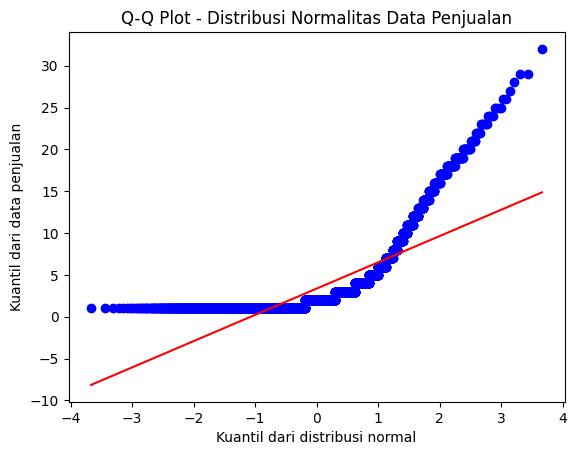

In [ ]:
from scipy import stats

stats.probplot(df_sales['Sales'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Distribusi Normalitas Data Penjualan')
plt.xlabel('Kuantil dari distribusi normal')
plt.ylabel('Kuantil dari data penjualan')
plt.show()

In [ ]:
df_sales.describe()

,Sales
count,5627.000000
mean,3.356495
std,3.921530
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,32.000000


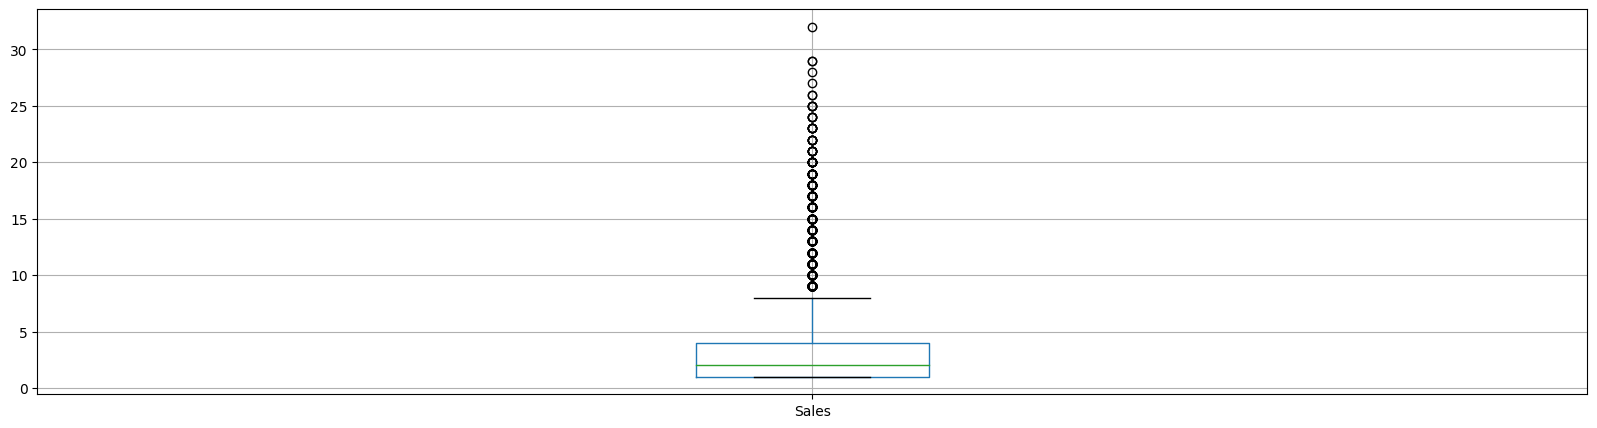

In [ ]:
# mengecek outlier
plt.figure(figsize=(20, 5))
boxplot = df_sales.boxplot(vert=True)

In [ ]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5627 entries, 0 to 5626
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Items     5627 non-null   object        
 1   Daypart   5627 non-null   object        
 2   DayType   5627 non-null   object        
 3   Category  5627 non-null   object        
 4   Date      5627 non-null   datetime64[ns]
 5   Sales     5627 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 263.9+ KB


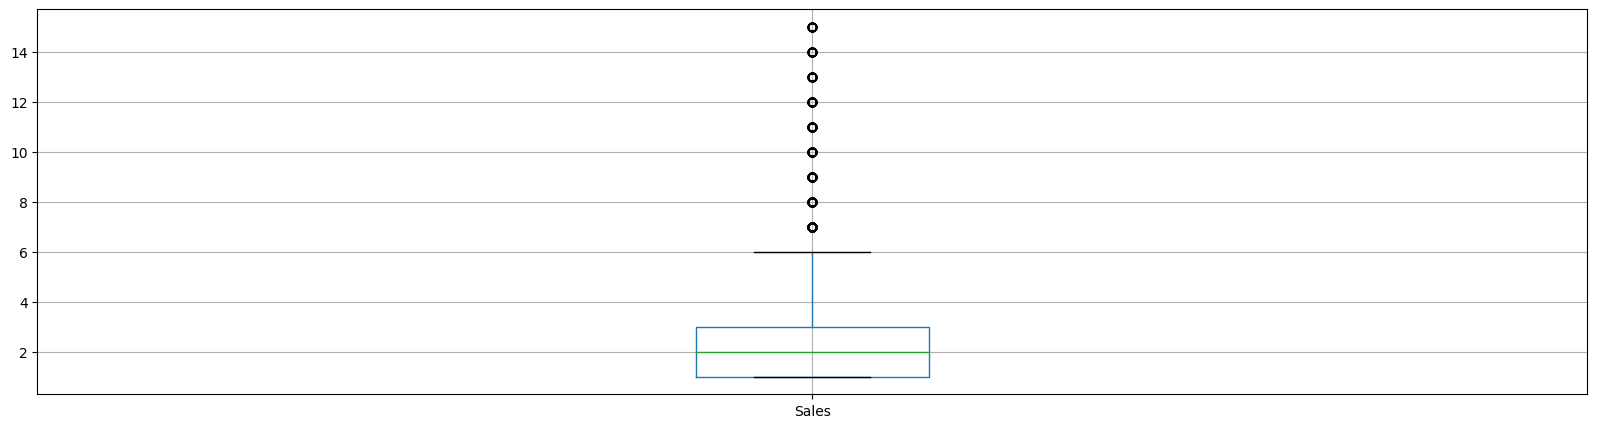

In [ ]:
from scipy.stats import zscore

z_scores = zscore(df_sales['Sales'])

# Tentukan batas threshold untuk menentukan data yang dianggap sebagai outlier
threshold = 3

# Filter data berdasarkan Z-score yang melebihi threshold
outlier_indices = np.where(np.abs(z_scores) > threshold)[0]

# Hapus outlier dari DataFrame
df_sales_no_outliers = df_sales.drop(outlier_indices)

# Visualisasi boxplot setelah menghapus outlier
plt.figure(figsize=(20, 5))
boxplot = df_sales_no_outliers.boxplot(column='Sales', vert=True)

### EDA

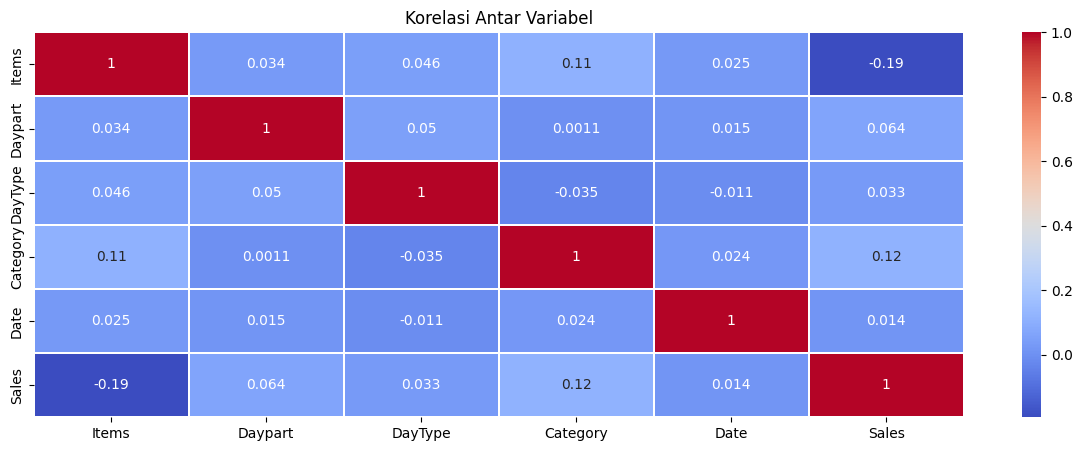

In [ ]:
# mengetahui korelasi antar variabel
plt.figure(figsize=(15, 5))
plt.title('Korelasi Antar Variabel')
corr = df_sales_no_outliers.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm')

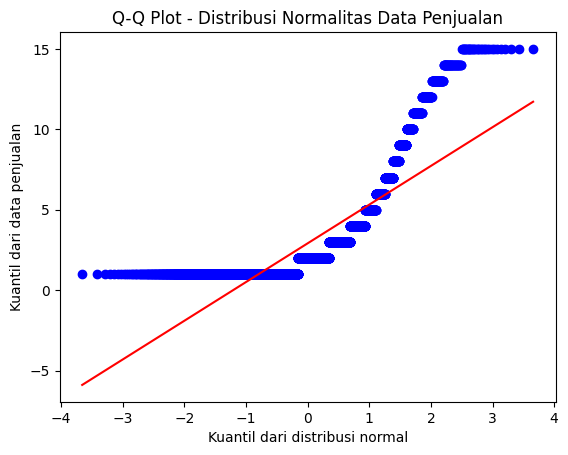

In [ ]:
from scipy import stats

stats.probplot(df_sales_no_outliers['Sales'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Distribusi Normalitas Data Penjualan')
plt.xlabel('Kuantil dari distribusi normal')
plt.ylabel('Kuantil dari data penjualan')
plt.show()

In [ ]:
corr

,Items,Daypart,DayType,Category,Date,Sales
Items,1.000000,0.033568,0.045517,0.110917,0.025478,-0.194362
Daypart,0.033568,1.000000,0.049590,0.001111,0.014864,0.064290
DayType,0.045517,0.049590,1.000000,-0.034538,-0.010853,0.032683
Category,0.110917,0.001111,-0.034538,1.000000,0.024354,0.117553
Date,0.025478,0.014864,-0.010853,0.024354,1.000000,0.013893
Sales,-0.194362,0.064290,0.032683,0.117553,0.013893,1.000000


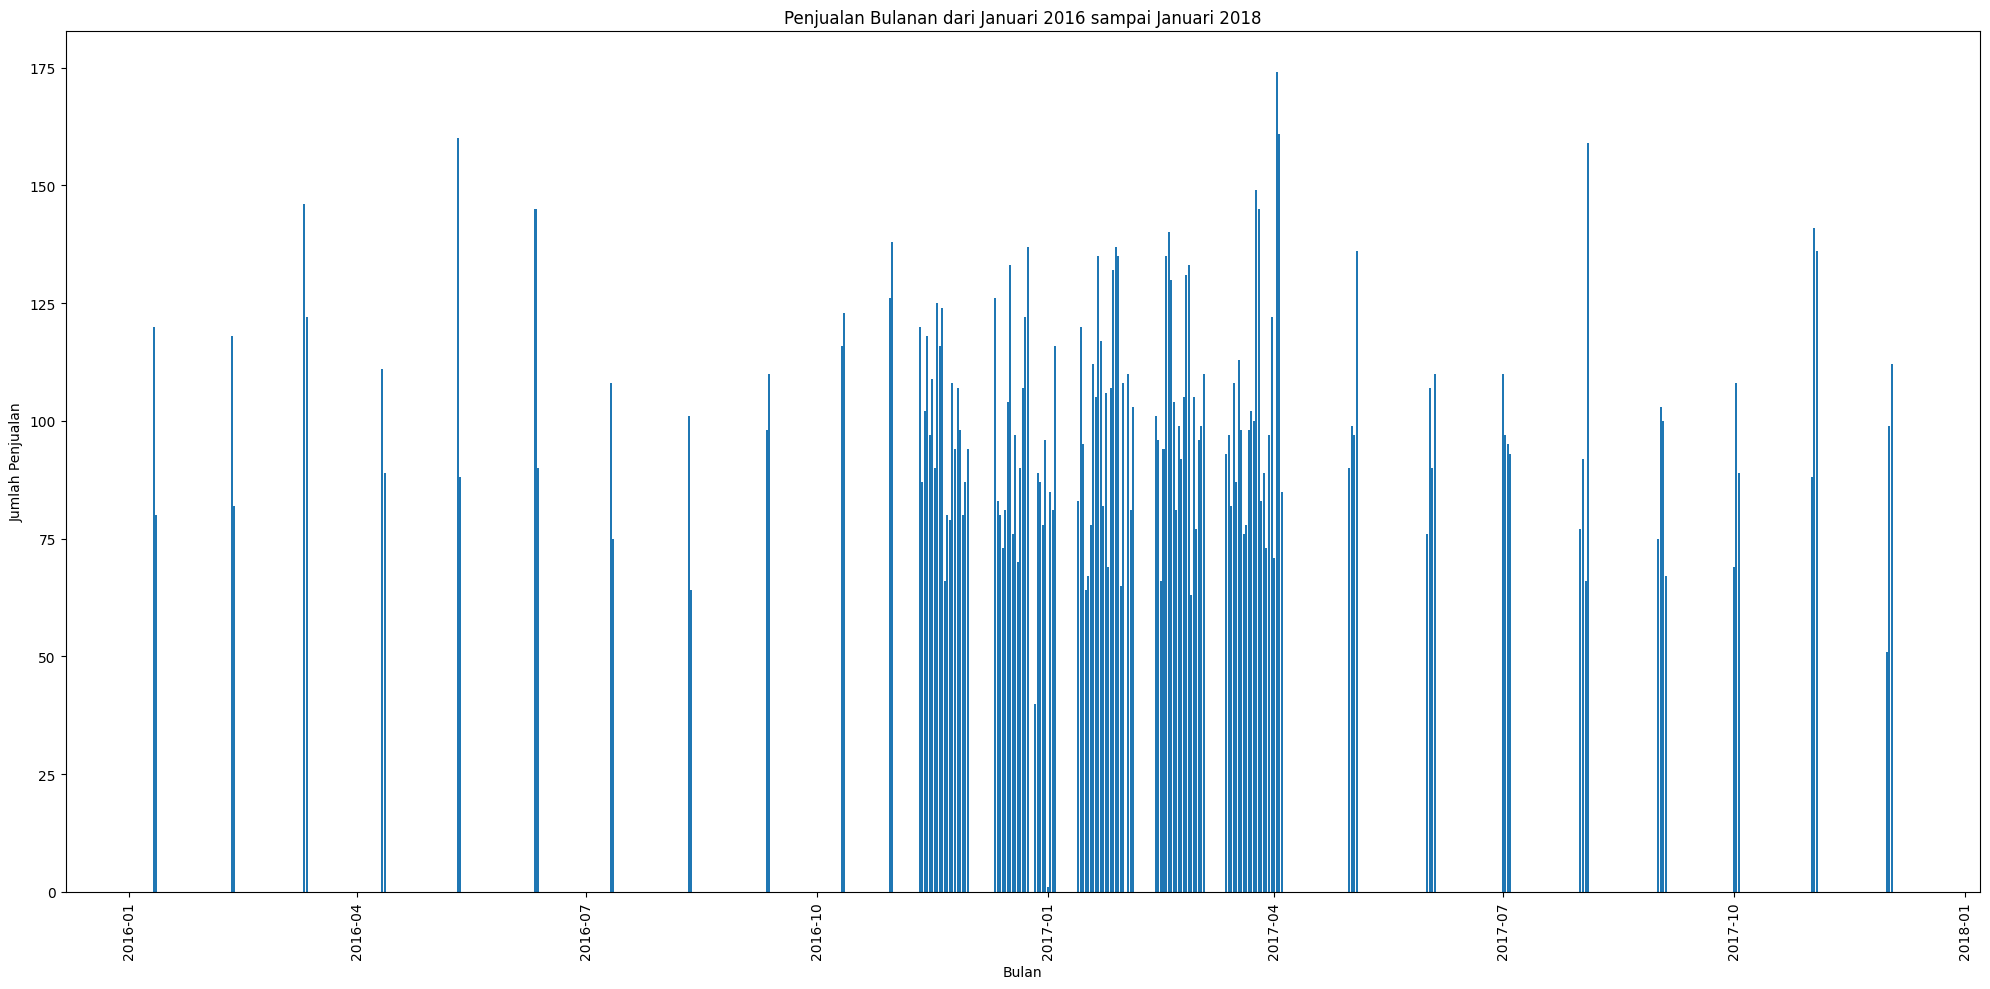

In [ ]:
monthly_sales = df_sales_no_outliers.groupby('Date')['Sales'].sum()

# Plotting grafik bar untuk penjualan bulanan
plt.figure(figsize=(20, 10))
plt.bar(monthly_sales.index, monthly_sales)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Penjualan')
plt.title('Penjualan Bulanan dari Januari 2016 sampai Januari 2018')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Dilihat dari grafik batang Penjualan bulan Januari 2016 sampai Januari 2018, dalam satu bulan terjadi transaksi di tanggal berbeda. Untuk mempermudah melihat total penjualan tiap minggu dalam sebulan, maka dari kolom date formatnya diubah menjadi Week.

In [ ]:
# mengubah kolom date menjadi minggu
df_sales_no_outliers['Date'] = df_sales_no_outliers['Date'].dt.to_period('W')
df_sales_no_outliers.head()

,Items,Daypart,DayType,Category,Date,Sales
0,Adjustment,Evening,Weekday,Accessories,2016-09-05/2016-09-11,1
1,Afternoon with the baker,Afternoon,Weekday,Food,2017-02-13/2017-02-19,1
2,Afternoon with the baker,Afternoon,Weekday,Food,2017-02-13/2017-02-19,2
3,Afternoon with the baker,Afternoon,Weekday,Food,2017-02-27/2017-03-05,1
4,Afternoon with the baker,Afternoon,Weekday,Food,2017-02-27/2017-03-05,2


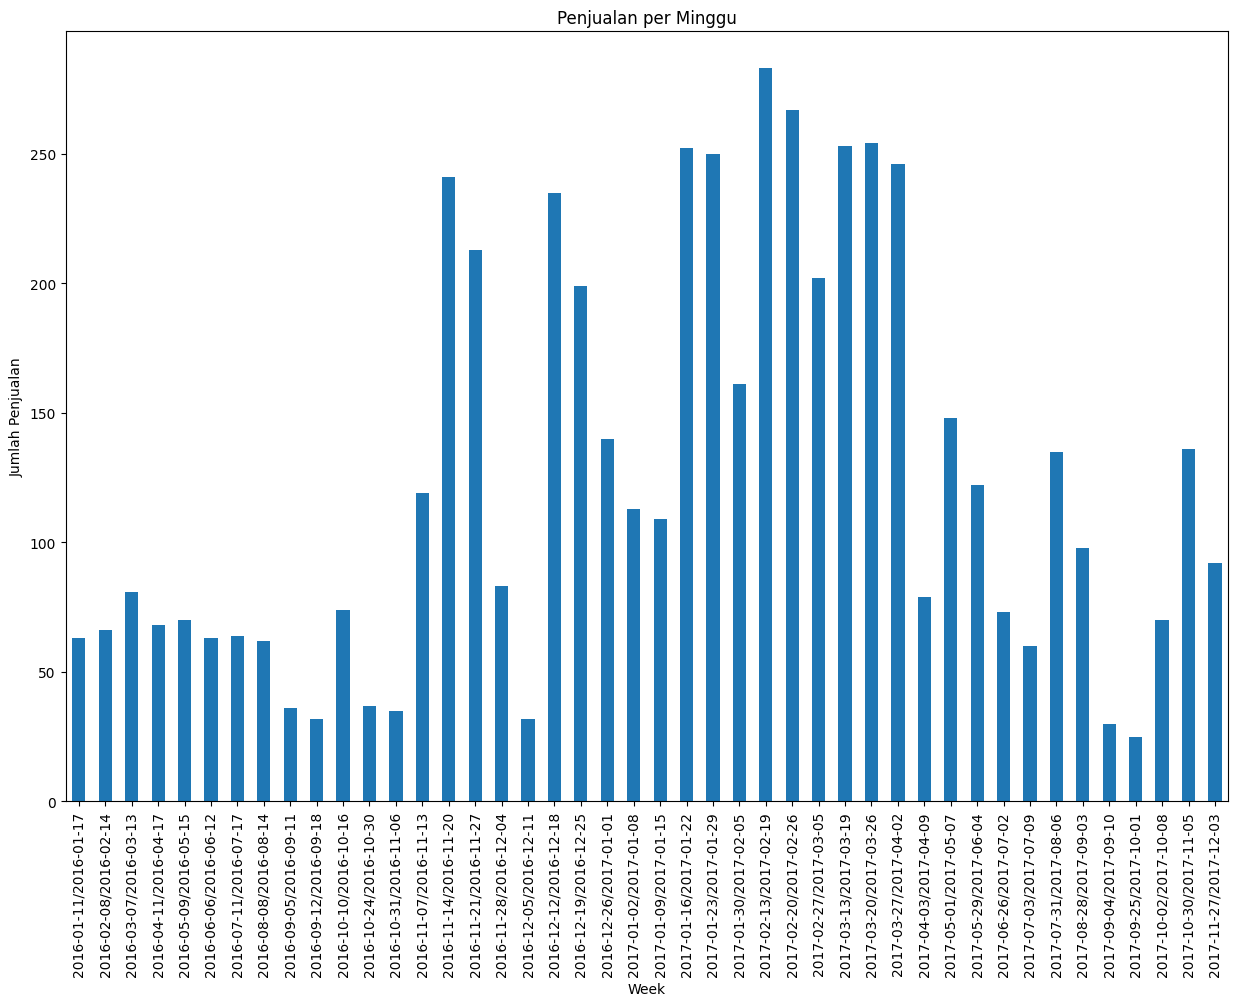

In [ ]:
# mengetahui penjualan tiap minggu
weekly_sales = df_sales_no_outliers.groupby('Date')['Sales'].count()

plt.figure(figsize=(15, 10))
ax = weekly_sales.plot(kind='bar', stacked=True)
plt.xlabel('Week')
plt.ylabel('Jumlah Penjualan')
plt.title('Penjualan per Minggu')
plt.show()

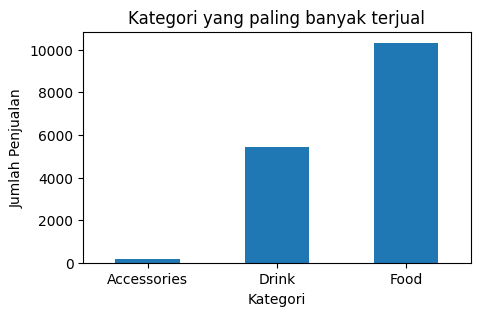

In [ ]:
# mengetahui penjualan kategori terbanyak
top_categories = df_sales_no_outliers.groupby('Category')['Sales'].sum()

plt.figure(figsize=(5, 3))
top_categories.plot(kind='bar')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Penjualan')
plt.xticks(rotation=0)
plt.title('Kategori yang paling banyak terjual')
plt.show()

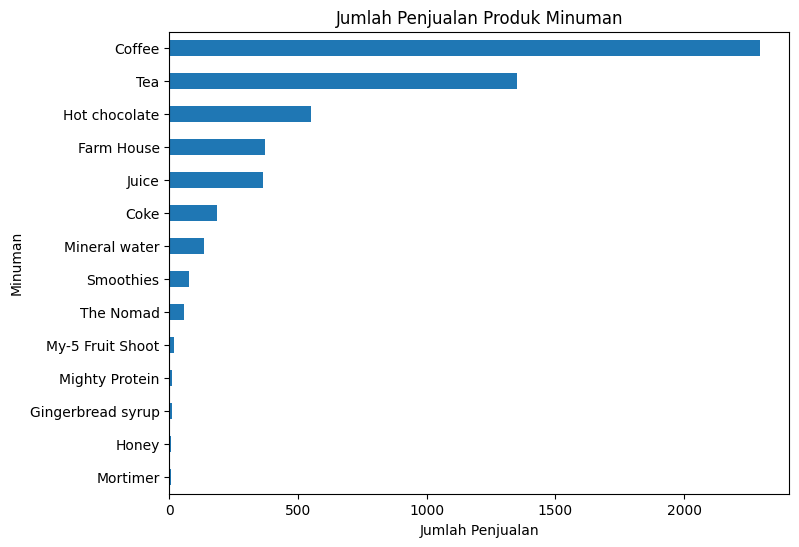

In [ ]:
# mengetahui jumlah penjualan produk minuman
drink_sales = df_sales_no_outliers[df_sales_no_outliers['Category'] == 'Drink']
drink_sales_count = drink_sales.groupby('Items')['Sales'].sum().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
drink_sales_count.plot(kind='barh')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Minuman')
plt.title('Jumlah Penjualan Produk Minuman')
plt.show()

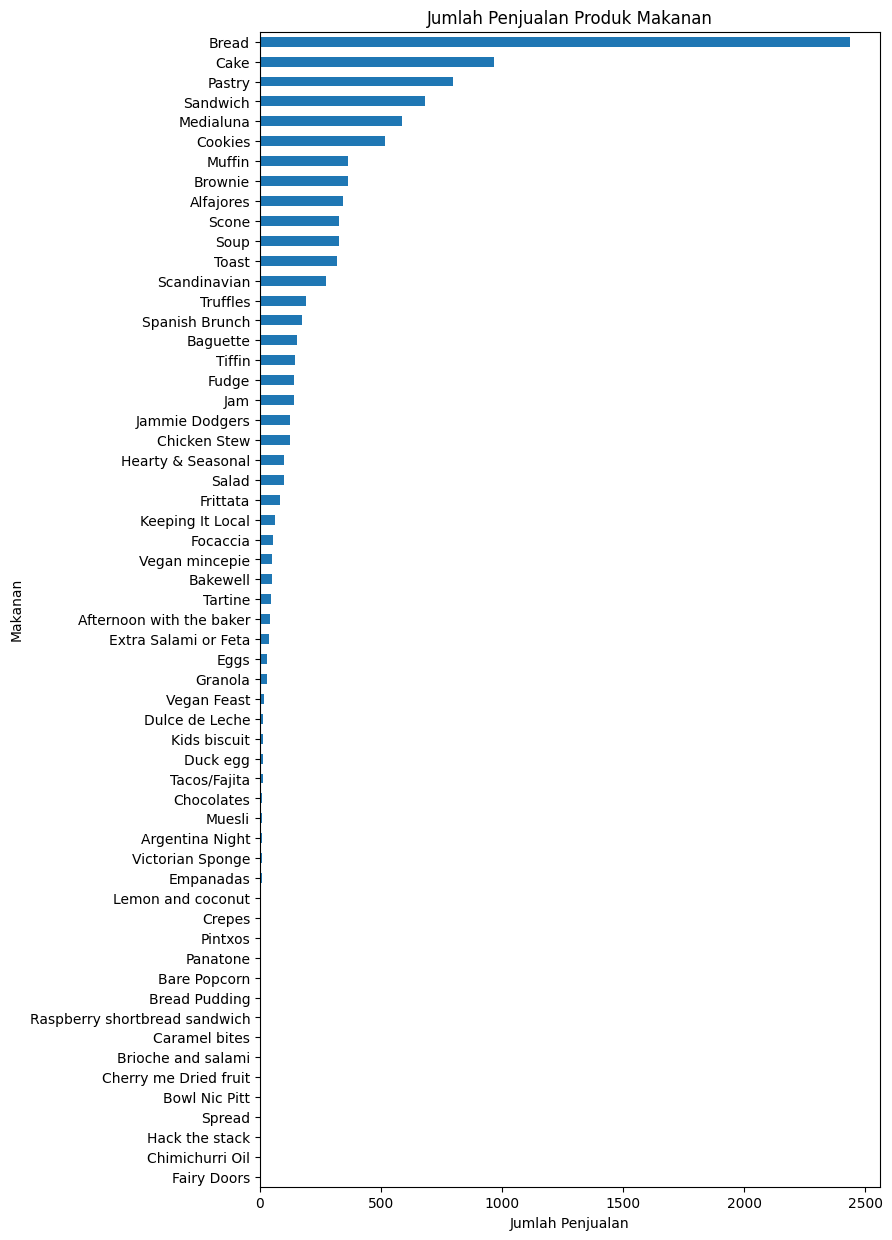

In [ ]:
# mengetahui jumlah penjualan produk makanan
food_sales = df_sales_no_outliers[df_sales_no_outliers['Category'] == 'Food']
food_sales_count = food_sales.groupby('Items')['Sales'].sum().sort_values(ascending=True)

plt.figure(figsize=(8, 15))
food_sales_count.plot(kind='barh')
plt.xlabel('Jumlah Penjualan')
plt.ylabel('Makanan')
plt.title('Jumlah Penjualan Produk Makanan')
plt.show()

Mengetahui distribusi penjualan minuman

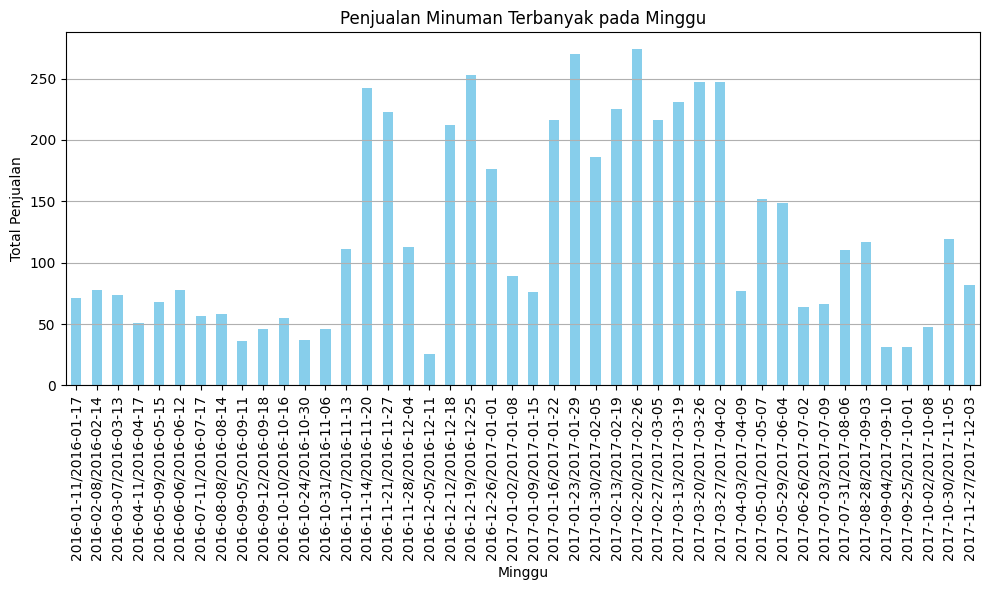

In [ ]:
# mengetahui penjualan minuman terbanyak pada minggu
week_sales = drink_sales.groupby(drink_sales['Date'])['Sales'].sum()

plt.figure(figsize=(10, 6))
week_sales.plot(kind='bar', color='skyblue')
plt.title('Penjualan Minuman Terbanyak pada Minggu')
plt.xlabel('Minggu')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

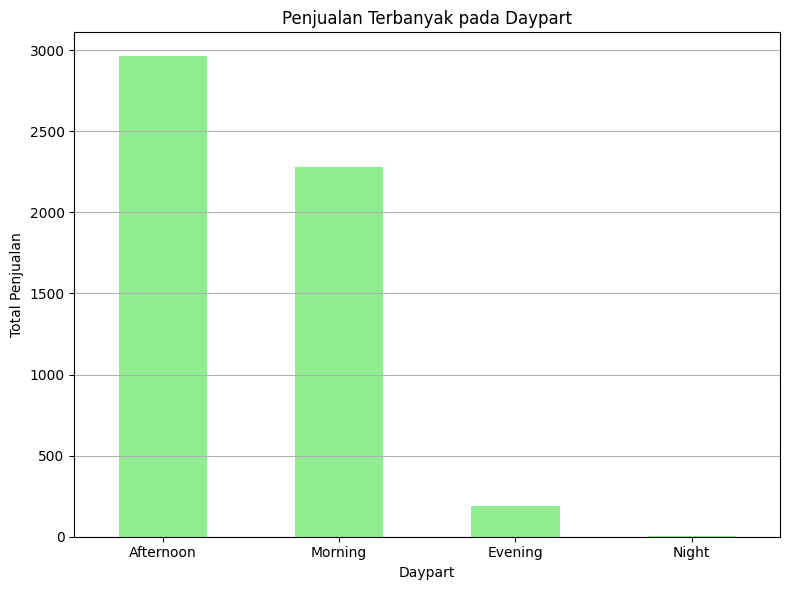

In [ ]:
# mengetahui penjualan terbanyak pada daypart
sales_by_daypart = drink_sales.groupby('Daypart')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sales_by_daypart.plot(kind='bar', color='lightgreen')
plt.title('Penjualan Terbanyak pada Daypart')
plt.xlabel('Daypart')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

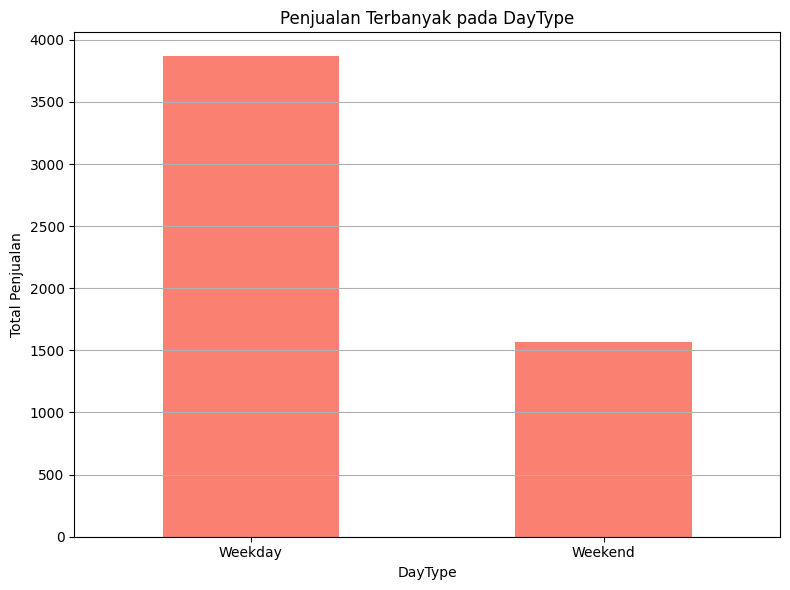

In [ ]:
# mengetahui penjualan terbanyak pada daytype
sales_by_daytype = drink_sales.groupby('DayType')['Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sales_by_daytype.plot(kind='bar', color='salmon')
plt.title('Penjualan Terbanyak pada DayType')
plt.xlabel('DayType')
plt.ylabel('Total Penjualan')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
drink_sales

,Items,Daypart,DayType,Category,Date,Sales
1216,Coffee,Afternoon,Weekday,Drink,2016-01-11/2016-01-17,14
1217,Coffee,Afternoon,Weekday,Drink,2016-02-08/2016-02-14,12
1218,Coffee,Afternoon,Weekday,Drink,2016-02-08/2016-02-14,10
1221,Coffee,Afternoon,Weekday,Drink,2016-05-09/2016-05-15,15
1222,Coffee,Afternoon,Weekday,Drink,2016-06-06/2016-06-12,13
...,...,...,...,...,...,...
5201,The Nomad,Morning,Weekend,Drink,2017-04-03/2017-04-09,1
5202,The Nomad,Morning,Weekend,Drink,2017-05-01/2017-05-07,1
5203,The Nomad,Morning,Weekend,Drink,2017-07-31/2017-08-06,3
5204,The Nomad,Morning,Weekend,Drink,2017-10-30/2017-11-05,1


### Feature Enginering

In [ ]:
week_drink_sales = drink_sales.copy()
week_drink_sales.head()

,Items,Daypart,DayType,Category,Date,Sales
1216,Coffee,Afternoon,Weekday,Drink,2016-01-11/2016-01-17,14
1217,Coffee,Afternoon,Weekday,Drink,2016-02-08/2016-02-14,12
1218,Coffee,Afternoon,Weekday,Drink,2016-02-08/2016-02-14,10
1221,Coffee,Afternoon,Weekday,Drink,2016-05-09/2016-05-15,15
1222,Coffee,Afternoon,Weekday,Drink,2016-06-06/2016-06-12,13


In [ ]:
week_drink_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1605 entries, 1216 to 5205
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype        
---  ------    --------------  -----        
 0   Items     1605 non-null   object       
 1   Daypart   1605 non-null   object       
 2   DayType   1605 non-null   object       
 3   Category  1605 non-null   object       
 4   Date      1605 non-null   period[W-SUN]
 5   Sales     1605 non-null   int64        
dtypes: int64(1), object(4), period[W-SUN](1)
memory usage: 87.8+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_cols = ['Items', 'Daypart', 'DayType', 'Category', 'Date']

for col in categorical_cols:
    week_drink_sales[col] = label_encoder.fit_transform(week_drink_sales[col])

In [ ]:
week_drink_sales.head()

,Items,Daypart,DayType,Category,Date,Sales
1216,0,0,0,0,0,14
1217,0,0,0,0,1,12
1218,0,0,0,0,1,10
1221,0,0,0,0,4,15
1222,0,0,0,0,5,13


### Modelling

In [ ]:
# memisahkan fitur dan target (sales)
X = week_drink_sales.drop('Sales', axis=1)
y = week_drink_sales['Sales']

In [ ]:
# membagi data menjadi data train dan data test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# membuat model XGBoost
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# melakukan prediksi
y_pred = model.predict(X_test)

In [ ]:
# menghitung metrik evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

Root Mean Squared Error (RMSE): 1.981061522408695
Mean Squared Error (MSE): 3.924604755568256
Mean Absolute Error (MAE): 1.3414588916315653
R-squared (R2) Score: 0.7134623297556971


Nilai Evaluasi RMSE, MSE dan MAE jauh dari nilai 0, dan nilai R2 jauh dari nilai 1, hal ini menunjukkan bahwa model kurang baik untuk melakukan prediksi

In [ ]:
# cross-vaidation dengan RMSE, MAE, R-Squared, dan MSE sebagai metrik evaluasi
rmse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_scores = -rmse_scores

mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_scores = -mae_scores

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -mse_scores

# menampilkan hasil cross-validation
print('Cross-Validation RMSE Scores:', rmse_scores)
print('Cross-Validation MAE Scores:', mae_scores)
print('Cross-Validation R^2 Scores:', r2_scores)
print('Cross-Validation MSE Scores:', mse_scores)

# rata-rata nilai dari hasil cross-validation
avg_rmse = rmse_scores.mean()
avg_mae = mae_scores.mean()
avg_r2 = r2_scores.mean()
avg_mse = mse_scores.mean()

print('\n')
print('Average RMSE:', avg_rmse)
print('Average MAE:', avg_mae)
print('Average R2:', avg_r2)
print('Average MSE:', avg_mse)

Cross-Validation RMSE Scores: [8.13013928 1.40799048 1.49405849 1.87497416 3.01690816]
Cross-Validation MAE Scores: [6.4223593  1.02254961 1.15506277 1.27803249 2.52401646]
Cross-Validation R^2 Scores: [-1.47056546 -0.36098067 -0.13803983  0.17870156 -0.42637765]
Cross-Validation MSE Scores: [66.09916478  1.98243719  2.23221078  3.5155281   9.10173487]


Average RMSE: 3.184814115589789
Average MAE: 2.480404123844944
Average R2: -0.44345240916388357
Average MSE: 16.586215142680167


In [ ]:
# melakukan hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Hyperparameter Tuning Results:')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

Hyperparameter Tuning Results:
Root Mean Squared Error (RMSE): 1.653903344296994
Mean Squared Error (MSE): 2.735396272276781
Mean Absolute Error (MAE): 1.1482248447394445
R-squared (R2) Score: 0.8002871310948989


In [ ]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Dari hasil hyperparameter tuning, model yang dibuat cukup baik karena nilai R2 mendekati nilai 1. Best model ketika learning rate = 0.05, max depth = 3, dan n estimators = 100.

Prediksi untuk minggu selanjutnya akan dilakukan dengan best model XGBoost.

<ipython-input-47-2a1b54edc93b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical['Date'] = historical['Date'].dt.strftime('%Y-%m-%d') + '/' + (historical['Date'] + 1).dt.strftime('%Y-%m-%d')


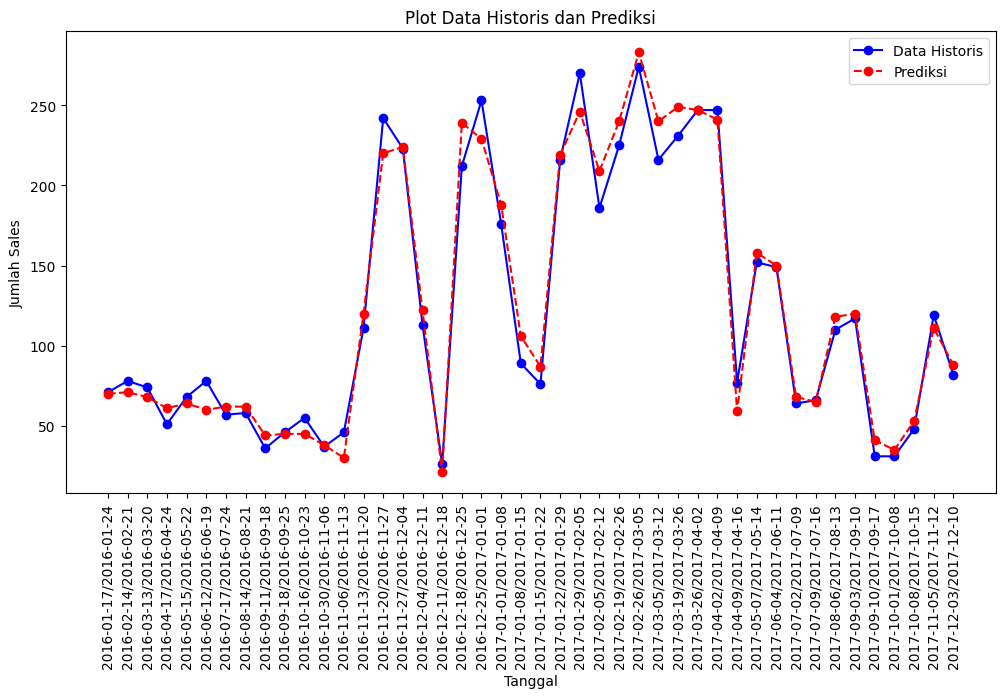

In [ ]:
# melihat data hasil prediksi dengan data asli
predicted = best_model.predict(X)

# mengembalikan nilai date ke nilai awal sebelum encode
week_drink_sales['Date'] = label_encoder.inverse_transform(week_drink_sales['Date'])

# data penjualan aktual
historical = week_drink_sales[['Date', 'Sales']]
historical['Date'] = historical['Date'].dt.strftime('%Y-%m-%d') + '/' + (historical['Date'] + 1).dt.strftime('%Y-%m-%d')

# data prediksi
predict = historical.copy()
predict.drop(['Sales'], axis=1, inplace=True)
predict['Predicted'] = np.round(predicted).astype(int)

# mengelompokkan penjualan aktual dan prediksi berdarkan Date
historical = historical.groupby('Date')['Sales'].sum()
historical = pd.DataFrame(historical)
historical.reset_index('Date', inplace=True)
historical

prediction = predict.groupby('Date')['Predicted'].sum()
prediction = pd.DataFrame(prediction)
prediction.reset_index('Date', inplace=True)
prediction

plt.figure(figsize=(12, 6))
plt.plot(historical['Date'], historical['Sales'], label='Data Historis', color='blue', marker='o')
plt.plot(prediction['Date'], prediction['Predicted'], label='Prediksi', color='red', linestyle='--', marker='o')
plt.legend()
plt.title('Plot Data Historis dan Prediksi')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Sales')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# menghitung jumlah transaksi per minggu
sales_per_week = week_drink_sales.groupby(week_drink_sales['Date'])['Sales'].count()

# menghitung rata-rata jumlah transaksi per minggu
average_sales_per_week = np.round(sales_per_week.mean())
average_sales_per_week

36.0

Rata-rata jumlah transaksi per minggu adalah 36. Untuk melakukan prediksi jumlah penjualan 4 minggu kedepan maka diperlukan 144 data dummy, dimana setiap minggu memiliki 36 transaksi.

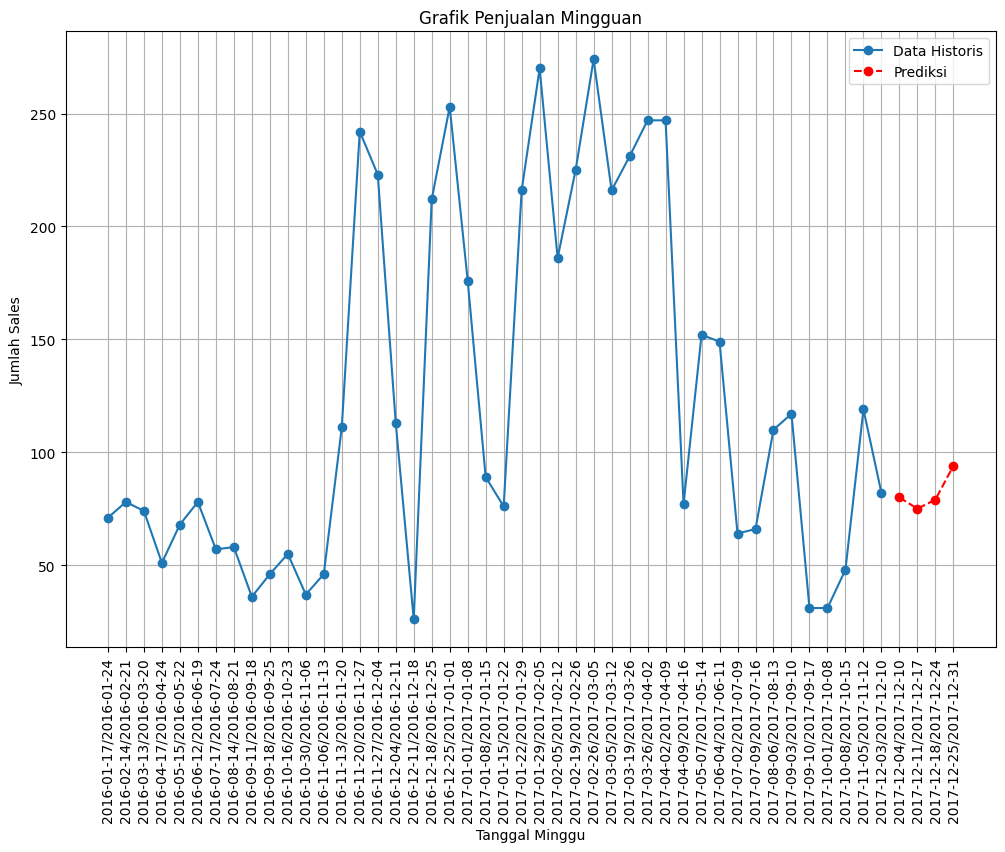

In [ ]:
# membuat prediksi untuk 4 minggu ke depan
predict_period = 4
last_date = week_drink_sales['Date'].sort_values().iloc[-1]
last_period = pd.Period(last_date, freq='W')
date_range = [str(last_period + i) for i in range(1, predict_period + 1)]

# membuat data dummy untuk fitur 'Items', 'Daypart', 'DayType', 'Category'
weeks = 4
transactions_per_week = 36

np.random.seed(42)

n_samples = predict_period * transactions_per_week
data_dummy = {
    'Items': np.random.randint(0, 14, size=n_samples),
    'Daypart': np.random.randint(0, 4, size=n_samples),
    'DayType': np.random.randint(0, 2, size=n_samples),
    'Category': np.random.randint(0, 1, size=n_samples)
}

# mengkonversi data acak menjadi DataFrame dan menambahkan kolom Date pada DataFrame
dummy_df = pd.DataFrame(data_dummy)
dummy_df['Date'] = np.repeat(date_range, transactions_per_week)

# mengubah urutan dataframe
predict_df = dummy_df[['Items', 'Daypart', 'DayType', 'Category', 'Date']]

# melakukan label encoding untuk kolom date
predict_df['Date'] = label_encoder.fit_transform(predict_df['Date'])

# melakukan prediksi dengan fitur-fitur acak yang dihasilkan
predict_sales = best_model.predict(predict_df)
predict_df['Predicted_Sales'] = predict_sales.round().astype(int)

# mengembalikan nilai kolom date sesuai nilai awal
predict_df['Date'] = label_encoder.inverse_transform(predict_df['Date'])

predict_df = pd.DataFrame(predict_df.groupby('Date')['Predicted_Sales'].sum())
predict_df.reset_index(inplace=True)

# menggabungkan data historis dengan prediksi
combined_data = pd.concat([historical, predict_df])

# Plot data historis dan prediksi
plt.figure(figsize=(12, 8))
plt.plot(combined_data['Date'], combined_data['Sales'], label='Data Historis', marker='o')
plt.plot(predict_df['Date'], predict_df['Predicted_Sales'], label='Prediksi', linestyle='--', marker='o', color='red')

plt.title('Grafik Penjualan Mingguan')
plt.xlabel('Tanggal Minggu')
plt.ylabel('Jumlah Sales')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
predict_df

,Date,Predicted_Sales
0,2017-12-04/2017-12-10,80
1,2017-12-11/2017-12-17,75
2,2017-12-18/2017-12-24,79
3,2017-12-25/2017-12-31,94


In [ ]:
historical['Sales'].mean()

123.5

In [ ]:
historical['Sales'].sum()

5434